# Klein Bottle from Dynamic Market Cycles

## Hypothesis

Insurance markets cycle (soft → hard → soft) with period ~7 years. A company’s optimal
insurance tower depends on both the **current market price** (loss ratio) and the
**current company size** (revenue/assets).

When a company experiences a full market cycle, it grows (or shrinks) endogenously
based on its ergodic outcomes. The company that enters the hard market at $5M is NOT
the same company that exits it — it may have grown to $8M during the cheap-insurance phase.

This creates **hysteresis**: the optimal tower at the same loss ratio differs between the
upswing and downswing of the cycle, because the company is a different size. The resulting
surface in `(loss_ratio, log(assets), optimal_deductible)` space self-intersects.

### Why a Klein Bottle?

The **twist** comes from direction-dependence:
- During the upswing (market hardening, insurance getting cheaper): optimal ded **falls**
- During the downswing (market softening, insurance getting expensive): optimal ded **rises**

At the self-intersection point, the surface normals point in opposite directions —
an orientation reversal. Combined with the closed-loop topology of the market cycle,
this produces a Klein Bottle.

In [1]:
"""Google Colab setup: mount Drive and install package dependencies."""
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    NOTEBOOK_DIR = '/content/drive/My Drive/Colab Notebooks/ei_notebooks/research'
    os.chdir(NOTEBOOK_DIR)
    if NOTEBOOK_DIR not in sys.path:
        sys.path.append(NOTEBOOK_DIR)
    !pip install ergodic-insurance -q 2>&1 | tail -3
    print('\nSetup complete.')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mticker
from scipy.interpolate import PchipInterpolator, RegularGridInterpolator
import warnings, logging, time, multiprocessing, itertools

warnings.filterwarnings("ignore")
logging.getLogger("ergodic_insurance").setLevel(logging.ERROR)

from ergodic_insurance.insurance_program import EnhancedInsuranceLayer, InsuranceProgram
from ergodic_insurance.loss_distributions import ManufacturingLossGenerator, LognormalLoss, ParetoLoss
from ergodic_insurance.insurance_pricing import LayerPricer

plt.style.use("seaborn-v0_8-darkgrid")
SEED = 42
np.random.seed(SEED)
N_CORES = multiprocessing.cpu_count()
print(f"Cores: {N_CORES}")

Cores: 16


## Shared Simulation Infrastructure

Loss model, analytical LEV-based layer pricing, tower factory, and CRN engine.
Compact version of the infrastructure from `optimization/09_tower_demand_curve.ipynb`.

In [3]:
# === Economic Parameters ===
ATR = 2.0
OPERATING_MARGIN = 0.15
REV_VOL = 0.50
INITIAL_ASSETS = 5_000_000
REFERENCE_REVENUE = ATR * INITIAL_ASSETS
FREQ_SCALING_EXPONENT = 0.75

# === Loss Model ===
ATTR_BASE_FREQ, ATTR_SEV_MEAN, ATTR_SEV_CV = 5, 10_000, 10
LG_BASE_FREQ, LG_SEV_MEAN, LG_SEV_CV = 1.75, 400_000, 5
CAT_BASE_FREQ, CAT_SEV_ALPHA, CAT_SEV_XM = 0.25, 2.01, 800_000

LOSS_PARAMS = dict(
    attritional_params={'base_frequency': ATTR_BASE_FREQ, 'severity_mean': ATTR_SEV_MEAN,
                        'severity_cv': ATTR_SEV_CV, 'revenue_scaling_exponent': FREQ_SCALING_EXPONENT,
                        'reference_revenue': REFERENCE_REVENUE},
    large_params={'base_frequency': LG_BASE_FREQ, 'severity_mean': LG_SEV_MEAN,
                  'severity_cv': LG_SEV_CV, 'revenue_scaling_exponent': FREQ_SCALING_EXPONENT,
                  'reference_revenue': REFERENCE_REVENUE},
    catastrophic_params={'base_frequency': CAT_BASE_FREQ, 'severity_alpha': CAT_SEV_ALPHA,
                         'severity_xm': CAT_SEV_XM, 'revenue_scaling_exponent': FREQ_SCALING_EXPONENT,
                         'reference_revenue': REFERENCE_REVENUE},
)

# === Layer Pricing ===
MIN_LAYER_MIDPOINT = np.mean([0, 5_000_000])
MAX_LAYER_MIDPOINT = np.mean([450_000_000, 500_000_000])

def make_layer_pricers(cur_revenue=REFERENCE_REVENUE):
    scale = (cur_revenue / REFERENCE_REVENUE) ** FREQ_SCALING_EXPONENT
    return (
        LayerPricer(LognormalLoss(mean=ATTR_SEV_MEAN, cv=ATTR_SEV_CV), frequency=ATTR_BASE_FREQ * scale),
        LayerPricer(LognormalLoss(mean=LG_SEV_MEAN, cv=LG_SEV_CV), frequency=LG_BASE_FREQ * scale),
        LayerPricer(ParetoLoss(alpha=CAT_SEV_ALPHA, xm=CAT_SEV_XM), frequency=CAT_BASE_FREQ * scale),
    )

DEFAULT_PRICERS = make_layer_pricers()

def analytical_layer_premium(attachment, limit, base_loss_ratio, loss_ratio_inflection, pricers=None):
    pricers = pricers or DEFAULT_PRICERS
    expected_loss = sum(p.expected_layer_loss(attachment, limit) for p in pricers)
    midpoint = np.mean([attachment, attachment + limit])
    layer_lr = base_loss_ratio + (1.0 / loss_ratio_inflection - 1.0) * base_loss_ratio \
               * (midpoint - MIN_LAYER_MIDPOINT) / (MAX_LAYER_MIDPOINT - MIN_LAYER_MIDPOINT)
    return expected_loss / layer_lr

def analytical_rate_on_line(attachment, limit, base_loss_ratio, loss_ratio_inflection, pricers=None):
    if limit <= 0: return 0.0
    return analytical_layer_premium(attachment, limit, base_loss_ratio, loss_ratio_inflection, pricers) / limit

# === Tower Factory (with layer truncation) ===
LAYER_DEFS = [(0, 5e6), (5e6, 10e6), (10e6, 25e6), (25e6, 50e6), (50e6, 100e6),
              (100e6, 150e6), (150e6, 200e6), (200e6, 250e6), (250e6, 300e6),
              (300e6, 350e6), (350e6, 400e6), (400e6, 450e6), (450e6, 500e6)]

def make_program(ded, base_loss_ratio, loss_ratio_inflection, max_limit=None, pricers=None):
    layers = []
    for attach, ceiling in LAYER_DEFS:
        if ded >= ceiling: continue
        if max_limit is not None and max_limit <= attach: continue
        eff_attach = max(attach, ded)
        eff_ceil = min(ceiling, max_limit) if max_limit is not None else ceiling
        limit = eff_ceil - eff_attach
        if limit <= 0: continue
        rol = analytical_rate_on_line(eff_attach, limit, base_loss_ratio, loss_ratio_inflection, pricers)
        layers.append(EnhancedInsuranceLayer(attachment_point=eff_attach, limit=limit,
                                              base_premium_rate=rol, reinstatements=0))
    return InsuranceProgram(layers=layers, deductible=ded,
                            name=f"Tower Ded=${ded:,.0f} Lim=${max_limit:,.0f}" if max_limit else f"Tower Ded=${ded:,.0f}")

# === CRN Loss Pool ===
def generate_loss_pool(n_paths, n_years, reference_revenue=REFERENCE_REVENUE, seed=SEED):
    ss = np.random.SeedSequence(seed)
    children = ss.spawn(n_paths + 1)
    rev_rng = np.random.default_rng(children[0])
    revenue_shocks = rev_rng.standard_normal((n_paths, n_years))
    all_losses = []
    for i in range(n_paths):
        gen = ManufacturingLossGenerator(**LOSS_PARAMS,
              seed=int(children[i + 1].generate_state(1)[0] % (2**31)))
        path_losses = []
        for t in range(n_years):
            events, _ = gen.generate_losses(duration=1.0, revenue=reference_revenue)
            path_losses.append(events)
        all_losses.append(path_losses)
    return revenue_shocks, all_losses

print("Infrastructure loaded.")

Infrastructure loaded.


## Step 1: Pre-compute Optimal Towers

Build a lookup table of optimal `(ded, max_limit)` for a grid of `(revenue, loss_ratio)` values.
This avoids re-running the full optimization at every time step during the dynamic simulation.

The sweep uses a coarse tower grid (fast) with 500 CRN paths per evaluation.

In [4]:
# === Pre-computation Parameters ===
GROWTH_WEIGHT = 0.75
VOL_WEIGHT = 0.25
RUIN_LIMIT = 0.005
N_SIM = 500  # paths per (ded, max_limit) combo

# Revenue grid: 12 values from $2M to $80M (geometric)
precomp_revenue_grid = np.geomspace(2_000_000, 80_000_000, 12)

# Loss ratio grid: 15 values from 0.40 to 0.90
precomp_lr_grid = np.linspace(0.40, 0.90, 15)

# Coarse tower grids for fast optimization
ded_grid = np.array([0, 50_000, 100_000, 250_000, 500_000, 750_000,
                     1_000_000, 1_500_000, 2_000_000, 3_000_000, 5_000_000,
                     10_000_000, 25_000_000, 50_000_000])
ml_grid = np.array([500_000, 1_000_000, 2_000_000, 5_000_000, 10_000_000,
                    25_000_000, 50_000_000, 100_000_000, 200_000_000, 500_000_000])

INFLECTION = 1.0  # Fixed for this experiment

scan_grid = list(itertools.product(precomp_revenue_grid, precomp_lr_grid))
n_valid = sum(1 for d in ded_grid for m in ml_grid if d < m)
print(f"Pre-computation: {len(scan_grid)} (revenue, LR) combos")
print(f"  x {n_valid} valid tower configs x {N_SIM} paths each")

def _optimize_one(args):
    """Find optimal tower for one (revenue, lr) combination."""
    revenue, base_lr, ded_arr, ml_arr, seed_base = args
    init_assets = revenue / ATR
    shocks, losses = generate_loss_pool(n_paths=N_SIM, n_years=1,
                                         reference_revenue=revenue, seed=seed_base)
    pricers = make_layer_pricers(cur_revenue=revenue)
    records = []
    for ded in ded_arr:
        for ml in ml_arr:
            if ded >= ml: continue
            program = make_program(ded, base_lr, INFLECTION, max_limit=ml, pricers=pricers)
            premium = program.calculate_premium()
            has_layers = len(program.layers) > 0
            W_T = np.empty(N_SIM)
            for i in range(N_SIM):
                assets = init_assets
                rev = assets * ATR * np.exp(REV_VOL * shocks[i, 0] - 0.5 * REV_VOL**2)
                op_inc = rev * OPERATING_MARGIN
                ls = (rev / revenue) ** FREQ_SCALING_EXPONENT
                ret = 0.0
                if has_layers:
                    prog = InsuranceProgram.create_fresh(program)
                    for ev in losses[i][0]:
                        r = prog.process_claim(ev.amount * ls)
                        ret += r.deductible_paid + r.uncovered_loss
                else:
                    for ev in losses[i][0]:
                        ret += ev.amount * ls
                assets += op_inc - ret - premium
                W_T[i] = max(assets, 0.0)
            log_g = np.log(np.maximum(W_T, 1.0) / init_assets)
            records.append({'revenue': revenue, 'base_lr': base_lr,
                           'ded': ded, 'max_limit': ml,
                           'growth_rate': np.mean(log_g), 'growth_vol': np.std(log_g),
                           'ruin_prob': np.mean(W_T <= 0), 'premium': premium})
    return records

# === Run sweep ===
inputs = [(rev, lr, ded_grid, ml_grid, SEED + i) for i, (rev, lr) in enumerate(scan_grid)]

t0 = time.time()
try:
    from joblib import Parallel, delayed
    results = Parallel(n_jobs=min(N_CORES, len(scan_grid)), verbose=5)(
        delayed(_optimize_one)(inp) for inp in inputs)
except Exception as e:
    print(f"Parallel failed ({e}), running serially...")
    from tqdm.auto import tqdm
    results = [_optimize_one(inp) for inp in tqdm(inputs, desc="Pre-compute")]

all_records = [r for batch in results for r in batch]
df_precomp = pd.DataFrame(all_records)
print(f"\nPre-computation done in {time.time()-t0:.1f}s ({len(df_precomp):,} rows)")

# === Select optimal tower per (revenue, lr) ===
optimal_lookup = {}
for (rev, lr), grp in df_precomp.groupby(['revenue', 'base_lr']):
    feasible = grp[grp['ruin_prob'] <= RUIN_LIMIT]
    if len(feasible) > 0:
        g = feasible['growth_rate'].values
        v = feasible['growth_vol'].values
        g_rng = max(g.max() - g.min(), 1e-12)
        v_rng = max(v.max() - v.min(), 1e-12)
        scores = GROWTH_WEIGHT * (g - g.min()) / g_rng + VOL_WEIGHT * (v.max() - v) / v_rng
        best = feasible.iloc[np.argmax(scores)]
    else:
        best = grp.loc[grp['ruin_prob'].idxmin()]
    optimal_lookup[(rev, lr)] = {
        'ded': best['ded'], 'max_limit': best['max_limit'],
        'growth_rate': best['growth_rate'], 'premium': best['premium'],
    }

print(f"Optimal lookup: {len(optimal_lookup)} entries")
# Show a few
for (rev, lr), opt in list(optimal_lookup.items())[:5]:
    print(f"  Rev=${rev/1e6:.1f}M  LR={lr:.2f}  ->  Ded=${opt['ded']:,.0f}  Lim=${opt['max_limit']:,.0f}  g={opt['growth_rate']:+.4f}")

Pre-computation: 180 (revenue, LR) combos
  x 106 valid tower configs x 500 paths each


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:   36.0s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:  2.0min
[Parallel(n_jobs=16)]: Done 180 out of 180 | elapsed:  3.9min finished



Pre-computation done in 232.1s (19,080 rows)
Optimal lookup: 180 entries
  Rev=$2.0M  LR=0.40  ->  Ded=$100,000  Lim=$25,000,000  g=-0.6486
  Rev=$2.0M  LR=0.44  ->  Ded=$250,000  Lim=$10,000,000  g=-0.4630
  Rev=$2.0M  LR=0.47  ->  Ded=$100,000  Lim=$5,000,000  g=-0.3696
  Rev=$2.0M  LR=0.51  ->  Ded=$100,000  Lim=$10,000,000  g=-0.3433
  Rev=$2.0M  LR=0.54  ->  Ded=$100,000  Lim=$5,000,000  g=-0.3046


## Step 2: Dynamic Market Cycle Simulation

Simulate multiple companies (different starting sizes) through a sinusoidal market cycle.
At each renewal year:
1. Look up the optimal tower from the pre-computed table (interpolated)
2. Simulate one year of operations with that tower
3. Update assets based on the median outcome across CRN paths
4. Record `(loss_ratio, log(assets), optimal_ded)` for the 3D surface

The second dimension of the surface comes from the family of companies at different
initial sizes, each tracing its own trajectory through the market cycle.

In [5]:
# === Market Cycle Parameters ===
CYCLE_PERIOD = 7       # years per full market cycle
LR_MEAN = 0.65         # center of cycle
LR_AMPLITUDE = 0.20    # LR oscillates between 0.45 and 0.85
N_CYCLES = 4
N_YEARS_TOTAL = CYCLE_PERIOD * N_CYCLES  # 28 years
N_COMPANIES = 15       # different starting sizes
N_SIM_DYNAMIC = 200    # paths per year for median outcome

# Company starting sizes (log-spaced from $1M to $40M assets)
starting_assets = np.geomspace(1_000_000, 40_000_000, N_COMPANIES)

# Pre-computed lookup keys for interpolation
lookup_revs = np.array(sorted(set(k[0] for k in optimal_lookup.keys())))
lookup_lrs = np.array(sorted(set(k[1] for k in optimal_lookup.keys())))

def interpolate_optimal(revenue, lr):
    """Find optimal tower for (revenue, lr) by nearest-neighbor in lookup table."""
    rev_idx = np.argmin(np.abs(lookup_revs - revenue))
    lr_idx = np.argmin(np.abs(lookup_lrs - lr))
    key = (lookup_revs[rev_idx], lookup_lrs[lr_idx])
    return optimal_lookup.get(key, {'ded': 1_000_000, 'max_limit': 10_000_000,
                                     'growth_rate': -0.05, 'premium': 100_000})

# === Run dynamic simulation ===
trajectories = []  # list of dicts: {company_idx, year, lr, assets, ded, ml, growth, premium}

t0 = time.time()
for c_idx, init_a in enumerate(starting_assets):
    assets = init_a
    for t in range(N_YEARS_TOTAL):
        # Current market loss ratio (sinusoidal cycle)
        lr = LR_MEAN + LR_AMPLITUDE * np.sin(2 * np.pi * t / CYCLE_PERIOD)
        lr = np.clip(lr, 0.40, 0.90)

        revenue = assets * ATR
        revenue = np.clip(revenue, lookup_revs.min(), lookup_revs.max())

        # Look up optimal tower
        opt = interpolate_optimal(revenue, lr)
        ded = opt['ded']
        ml = opt['max_limit']

        # Simulate one year with this tower
        shocks, losses = generate_loss_pool(n_paths=N_SIM_DYNAMIC, n_years=1,
                                             reference_revenue=revenue,
                                             seed=SEED + c_idx * 1000 + t)
        pricers = make_layer_pricers(cur_revenue=revenue)

        if ded < ml:
            program = make_program(ded, lr, INFLECTION, max_limit=ml, pricers=pricers)
            premium = program.calculate_premium()
            has_layers = len(program.layers) > 0
        else:
            premium = 0.0
            has_layers = False
            program = None

        W_T = np.empty(N_SIM_DYNAMIC)
        for i in range(N_SIM_DYNAMIC):
            a = assets
            rev = a * ATR * np.exp(REV_VOL * shocks[i, 0] - 0.5 * REV_VOL**2)
            op_inc = rev * OPERATING_MARGIN
            ls = (rev / revenue) ** FREQ_SCALING_EXPONENT
            ret = 0.0
            if has_layers:
                prog = InsuranceProgram.create_fresh(program)
                for ev in losses[i][0]:
                    r = prog.process_claim(ev.amount * ls)
                    ret += r.deductible_paid + r.uncovered_loss
            else:
                for ev in losses[i][0]:
                    ret += ev.amount * ls
            a += op_inc - ret - premium
            W_T[i] = max(a, 0.0)

        # Use median outcome to advance the company
        median_wealth = np.median(W_T)
        log_g = np.log(max(median_wealth, 1.0) / max(assets, 1.0))

        trajectories.append({
            'company': c_idx, 'year': t, 'cycle_phase': 2 * np.pi * t / CYCLE_PERIOD,
            'lr': lr, 'assets': assets, 'log_assets': np.log10(max(assets, 1)),
            'revenue': revenue, 'ded': ded, 'max_limit': ml, 'log_ded': np.log10(max(ded, 1)),
            'premium': premium, 'growth_rate': log_g,
            'median_wealth': median_wealth,
        })

        # Update assets for next year
        assets = max(median_wealth, 1_000)  # floor to prevent zero

elapsed = time.time() - t0
df_traj = pd.DataFrame(trajectories)
print(f"Simulation done in {elapsed:.1f}s")
print(f"  {N_COMPANIES} companies x {N_YEARS_TOTAL} years = {len(df_traj)} data points")
print(f"  Asset range: ${df_traj['assets'].min():,.0f} - ${df_traj['assets'].max():,.0f}")
print(f"  LR range: {df_traj['lr'].min():.2f} - {df_traj['lr'].max():.2f}")

Simulation done in 55.9s
  15 companies x 28 years = 420 data points
  Asset range: $1,000 - $5,633,615,872
  LR range: 0.46 - 0.84


## Step 3: 3D Surface Visualization

Plot company trajectories in `(loss_ratio, log₁₀(assets), log₁₀(optimal_ded))` space.

Each company traces a **spiral** as the market cycles. If hysteresis is present,
the upswing and downswing spirals will diverge — the same loss ratio maps to a
different optimal deductible depending on company size, which itself depends on
the direction of the cycle.

The surface formed by interpolating across the family of companies should show
**self-intersection** where upswing and downswing sheets cross.

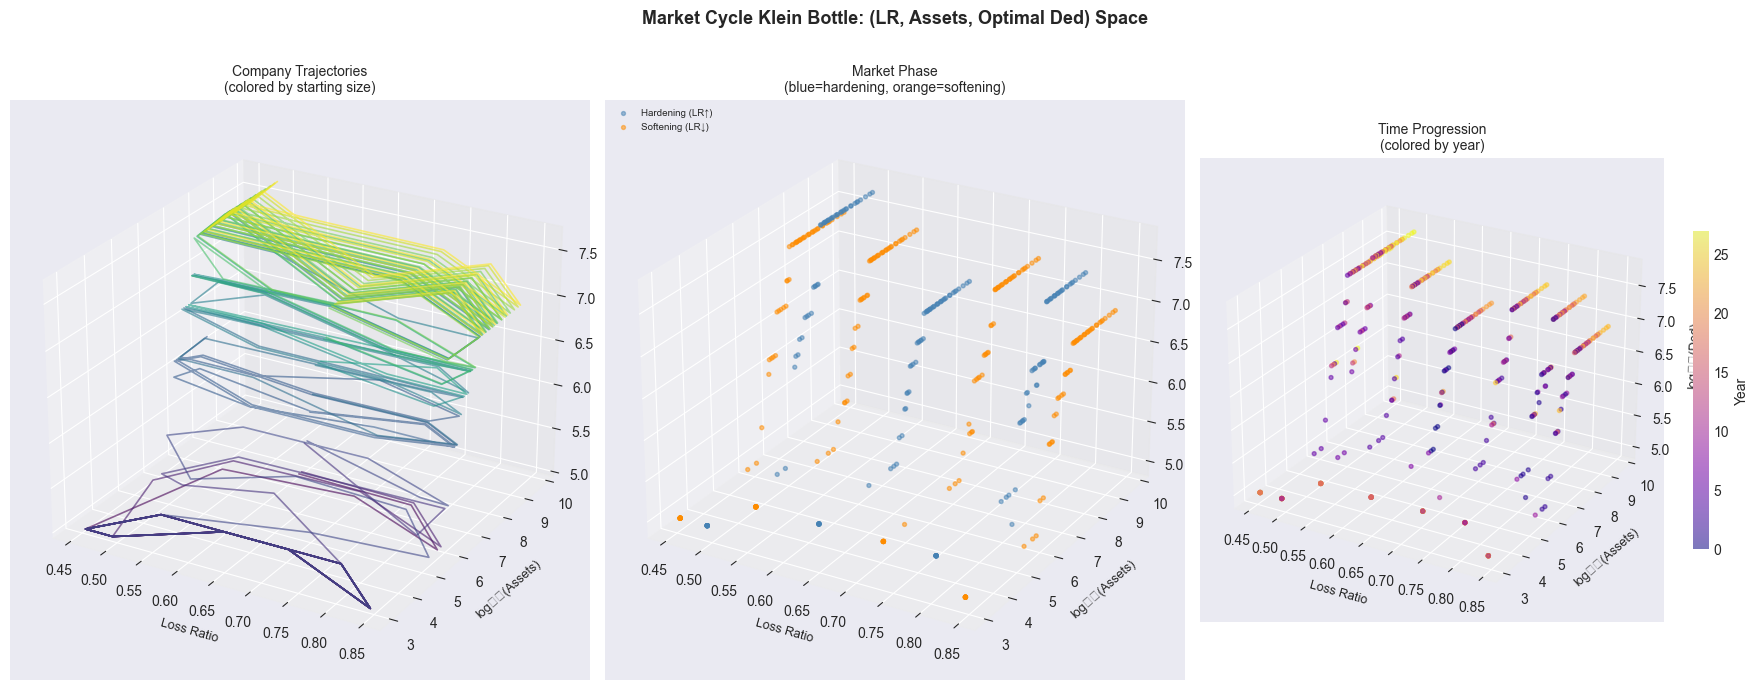

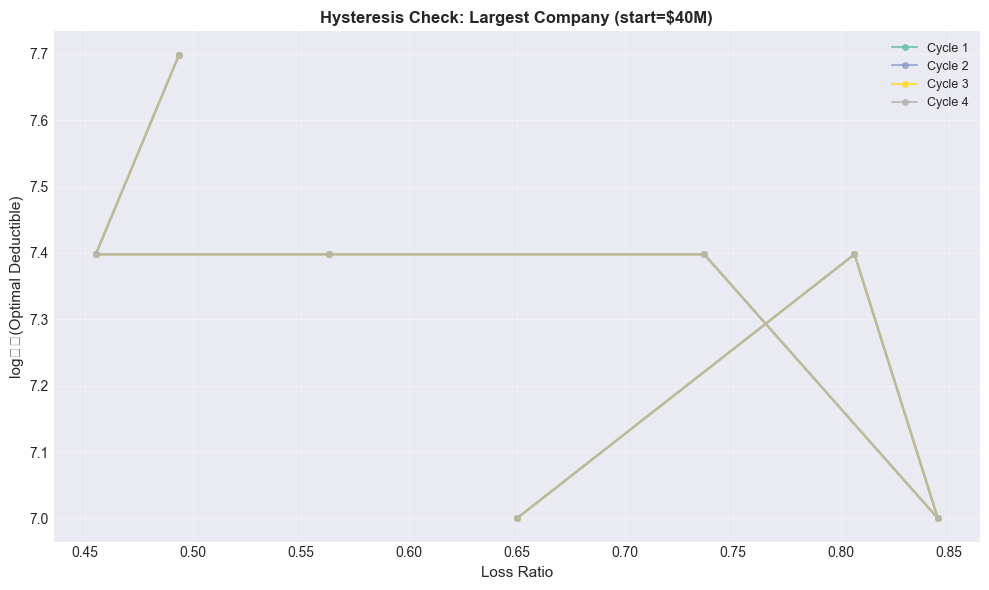


Largest company asset evolution:
  Cycle 1: assets $40.0M → $105.3M
  Cycle 2: assets $123.9M → $358.7M
  Cycle 3: assets $423.1M → $1338.1M
  Cycle 4: assets $1611.8M → $5633.6M


In [6]:
fig = plt.figure(figsize=(18, 7))

# --- Panel 1: All trajectories colored by company ---
ax1 = fig.add_subplot(131, projection='3d')
cmap_co = plt.cm.viridis(np.linspace(0, 1, N_COMPANIES))
for c_idx in range(N_COMPANIES):
    sub = df_traj[df_traj['company'] == c_idx].sort_values('year')
    ax1.plot(sub['lr'].values, sub['log_assets'].values, sub['log_ded'].values,
             color=cmap_co[c_idx], alpha=0.6, linewidth=1.2)
ax1.set_xlabel('Loss Ratio', fontsize=9)
ax1.set_ylabel('log₁₀(Assets)', fontsize=9)
ax1.set_zlabel('log₁₀(Ded)', fontsize=9)
ax1.set_title('Company Trajectories\n(colored by starting size)', fontsize=10)
ax1.view_init(elev=25, azim=-60)

# --- Panel 2: Surface colored by cycle phase (upswing vs downswing) ---
ax2 = fig.add_subplot(132, projection='3d')
# Classify upswing (dLR/dt > 0) vs downswing (dLR/dt < 0)
# dLR/dt = LR_AMPLITUDE * 2pi/T * cos(2pi*t/T)
df_traj['dlr_dt'] = LR_AMPLITUDE * (2 * np.pi / CYCLE_PERIOD) * np.cos(df_traj['cycle_phase'])
df_traj['phase_label'] = np.where(df_traj['dlr_dt'] > 0, 'hardening', 'softening')

up = df_traj[df_traj['phase_label'] == 'hardening']
dn = df_traj[df_traj['phase_label'] == 'softening']
ax2.scatter(up['lr'], up['log_assets'], up['log_ded'], c='steelblue', s=8,
            alpha=0.5, label='Hardening (LR↑)')
ax2.scatter(dn['lr'], dn['log_assets'], dn['log_ded'], c='darkorange', s=8,
            alpha=0.5, label='Softening (LR↓)')
ax2.set_xlabel('Loss Ratio', fontsize=9)
ax2.set_ylabel('log₁₀(Assets)', fontsize=9)
ax2.set_zlabel('log₁₀(Ded)', fontsize=9)
ax2.set_title('Market Phase\n(blue=hardening, orange=softening)', fontsize=10)
ax2.legend(fontsize=7, loc='upper left')
ax2.view_init(elev=25, azim=-60)

# --- Panel 3: Surface colored by year (time progression) ---
ax3 = fig.add_subplot(133, projection='3d')
sc = ax3.scatter(df_traj['lr'], df_traj['log_assets'], df_traj['log_ded'],
                 c=df_traj['year'], cmap='plasma', s=8, alpha=0.5)
ax3.set_xlabel('Loss Ratio', fontsize=9)
ax3.set_ylabel('log₁₀(Assets)', fontsize=9)
ax3.set_zlabel('log₁₀(Ded)', fontsize=9)
ax3.set_title('Time Progression\n(colored by year)', fontsize=10)
fig.colorbar(sc, ax=ax3, shrink=0.5, label='Year')
ax3.view_init(elev=25, azim=-60)

fig.suptitle('Market Cycle Klein Bottle: (LR, Assets, Optimal Ded) Space',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# --- Panel 4: Single company detail (largest, most visible hysteresis) ---
fig2, ax4 = plt.subplots(figsize=(10, 6))
# Show 2D projection: LR vs log_ded colored by cycle number
c_show = N_COMPANIES - 1  # largest company
sub = df_traj[df_traj['company'] == c_show].copy()
sub['cycle_num'] = sub['year'] // CYCLE_PERIOD

colors_cycle = plt.cm.Set2(np.linspace(0, 1, N_CYCLES))
for cyc in range(N_CYCLES):
    csub = sub[sub['cycle_num'] == cyc].sort_values('year')
    ax4.plot(csub['lr'], csub['log_ded'], '-o', color=colors_cycle[cyc],
             markersize=4, linewidth=1.5, alpha=0.8, label=f'Cycle {cyc+1}')

ax4.set_xlabel('Loss Ratio', fontsize=11)
ax4.set_ylabel('log₁₀(Optimal Deductible)', fontsize=11)
ax4.set_title(f'Hysteresis Check: Largest Company (start=${starting_assets[c_show]/1e6:.0f}M)',
              fontsize=12, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nLargest company asset evolution:")
for cyc in range(N_CYCLES):
    csub = sub[sub['cycle_num'] == cyc]
    print(f"  Cycle {cyc+1}: assets ${csub['assets'].iloc[0]/1e6:.1f}M → ${csub['assets'].iloc[-1]/1e6:.1f}M")

## Step 4: Hysteresis & Self-Intersection Analysis

Quantify the hysteresis by comparing upswing vs downswing behavior at the same loss ratio.
For each company, split the trajectory into hardening and softening half-cycles,
then check whether the optimal deductible differs at the same `(LR, assets)` pair
depending on the market direction.

Self-intersection is detected using a KDTree in the 3D outcome space
`(LR, log_assets, log_ded)`, looking for pairs of points that are close in
outcome space but come from **opposite** market phases.

In [7]:
from scipy.spatial import KDTree

# ============================================================
# 1. HYSTERESIS MEASURE
# ============================================================
# For each company, at each LR value that appears in both hardening and
# softening phases, measure the difference in log_ded and log_assets.

hysteresis_records = []
for c_idx in range(N_COMPANIES):
    sub = df_traj[df_traj['company'] == c_idx]
    up = sub[sub['phase_label'] == 'hardening']
    dn = sub[sub['phase_label'] == 'softening']

    # Bin LR values to compare phases at similar market conditions
    lr_bins = np.linspace(0.45, 0.85, 20)
    up_binned = pd.cut(up['lr'], lr_bins)
    dn_binned = pd.cut(dn['lr'], lr_bins)

    for b in lr_bins[:-1]:
        b_up = up[(up['lr'] >= b) & (up['lr'] < b + (lr_bins[1] - lr_bins[0]))]
        b_dn = dn[(dn['lr'] >= b) & (dn['lr'] < b + (lr_bins[1] - lr_bins[0]))]
        if len(b_up) > 0 and len(b_dn) > 0:
            delta_ded = b_up['log_ded'].mean() - b_dn['log_ded'].mean()
            delta_assets = b_up['log_assets'].mean() - b_dn['log_assets'].mean()
            hysteresis_records.append({
                'company': c_idx,
                'lr_bin': b,
                'delta_log_ded': delta_ded,
                'delta_log_assets': delta_assets,
                'n_up': len(b_up),
                'n_dn': len(b_dn),
            })

df_hyst = pd.DataFrame(hysteresis_records)
if len(df_hyst) > 0:
    print("=== HYSTERESIS SUMMARY ===")
    print(f"Mean |Δlog₁₀(ded)| between hardening & softening: "
          f"{df_hyst['delta_log_ded'].abs().mean():.4f}")
    print(f"Mean |Δlog₁₀(assets)| between hardening & softening: "
          f"{df_hyst['delta_log_assets'].abs().mean():.4f}")
    print(f"Max  |Δlog₁₀(ded)|: {df_hyst['delta_log_ded'].abs().max():.4f}")
    print(f"\nBy company (avg |Δlog₁₀(ded)|):")
    for c_idx in range(N_COMPANIES):
        ch = df_hyst[df_hyst['company'] == c_idx]
        if len(ch) > 0:
            print(f"  Company {c_idx:2d} (start ${starting_assets[c_idx]/1e6:6.1f}M): "
                  f"|Δded|={ch['delta_log_ded'].abs().mean():.4f}  "
                  f"|Δassets|={ch['delta_log_assets'].abs().mean():.4f}")

# ============================================================
# 2. SELF-INTERSECTION DETECTION (opposite-phase pairs)
# ============================================================
print("\n=== SELF-INTERSECTION DETECTION ===")

# Normalize outcome dimensions
cols = ['lr', 'log_assets', 'log_ded']
X = df_traj[cols].values.copy()
X_min = X.min(axis=0)
X_max = X.max(axis=0)
X_rng = X_max - X_min
X_rng[X_rng == 0] = 1.0
X_norm = (X - X_min) / X_rng

# Build KDTree on normalized outcomes
tree = KDTree(X_norm)
THRESHOLD = 0.05  # close in outcome space

# Find all pairs within threshold
pairs = tree.query_pairs(r=THRESHOLD)
print(f"Total close pairs (r<{THRESHOLD}): {len(pairs)}")

# Filter: keep only pairs from opposite market phases
cross_phase_pairs = []
phase_arr = df_traj['phase_label'].values
company_arr = df_traj['company'].values
year_arr = df_traj['year'].values

for i, j in pairs:
    if phase_arr[i] != phase_arr[j]:
        # Compute distance in parameter space (company × year)
        outcome_dist = np.linalg.norm(X_norm[i] - X_norm[j])
        cross_phase_pairs.append({
            'i': i, 'j': j,
            'company_i': company_arr[i], 'company_j': company_arr[j],
            'year_i': year_arr[i], 'year_j': year_arr[j],
            'phase_i': phase_arr[i], 'phase_j': phase_arr[j],
            'outcome_dist': outcome_dist,
            'lr_i': df_traj.iloc[i]['lr'], 'lr_j': df_traj.iloc[j]['lr'],
            'log_ded_i': df_traj.iloc[i]['log_ded'], 'log_ded_j': df_traj.iloc[j]['log_ded'],
            'log_assets_i': df_traj.iloc[i]['log_assets'], 'log_assets_j': df_traj.iloc[j]['log_assets'],
        })

df_cross = pd.DataFrame(cross_phase_pairs)
print(f"Cross-phase close pairs: {len(df_cross)}")

if len(df_cross) > 0:
    # Same-company cross-phase pairs are the strongest hysteresis signal
    same_co = df_cross[df_cross['company_i'] == df_cross['company_j']]
    diff_co = df_cross[df_cross['company_i'] != df_cross['company_j']]
    print(f"  Same company: {len(same_co)}  |  Different company: {len(diff_co)}")

    if len(same_co) > 0:
        print(f"\n  Top 10 same-company self-intersections (by outcome closeness):")
        top = same_co.nsmallest(10, 'outcome_dist')
        for _, row in top.iterrows():
            print(f"    Co {int(row['company_i']):2d}  yr {int(row['year_i']):2d}({row['phase_i'][:4]}) "
                  f"↔ yr {int(row['year_j']):2d}({row['phase_j'][:4]})  "
                  f"LR={row['lr_i']:.2f}/{row['lr_j']:.2f}  "
                  f"dist={row['outcome_dist']:.4f}")

# ============================================================
# 3. VISUALIZATION: Hysteresis heatmap
# ============================================================
if len(df_hyst) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Heatmap: company x LR-bin → delta_log_ded
    pivot = df_hyst.pivot_table(values='delta_log_ded', index='company',
                                 columns='lr_bin', aggfunc='mean')
    im = ax1.imshow(pivot.values, aspect='auto', cmap='RdBu_r',
                     vmin=-pivot.values[np.isfinite(pivot.values)].max(),
                     vmax=pivot.values[np.isfinite(pivot.values)].max())
    ax1.set_xlabel('LR Bin Index', fontsize=10)
    ax1.set_ylabel('Company Index', fontsize=10)
    ax1.set_title('Hysteresis: Δlog₁₀(ded)\n(hardening − softening)', fontsize=11, fontweight='bold')
    fig.colorbar(im, ax=ax1, shrink=0.8, label='Δlog₁₀(ded)')

    # Cross-phase intersection scatter
    if len(df_cross) > 0:
        ax2.scatter(df_cross['lr_i'], df_cross['log_assets_i'], c='steelblue',
                    s=12, alpha=0.4, label='Hardening point')
        ax2.scatter(df_cross['lr_j'], df_cross['log_assets_j'], c='darkorange',
                    s=12, alpha=0.4, label='Softening point')
        # Draw lines connecting pairs
        for _, row in df_cross.sample(min(50, len(df_cross)), random_state=42).iterrows():
            ax2.plot([row['lr_i'], row['lr_j']],
                     [row['log_assets_i'], row['log_assets_j']],
                     'k-', alpha=0.1, linewidth=0.5)
        ax2.set_xlabel('Loss Ratio', fontsize=10)
        ax2.set_ylabel('log₁₀(Assets)', fontsize=10)
        ax2.set_title(f'Cross-Phase Self-Intersections\n({len(df_cross)} pairs)', fontsize=11, fontweight='bold')
        ax2.legend(fontsize=8)
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'No cross-phase\nintersections found',
                 ha='center', va='center', fontsize=14, transform=ax2.transAxes)
        ax2.set_title('Cross-Phase Self-Intersections', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.show()

# ============================================================
# 4. SUMMARY VERDICT
# ============================================================
print("\n" + "="*60)
print("KLEIN BOTTLE VERDICT")
print("="*60)
if len(df_hyst) > 0:
    mean_hyst = df_hyst['delta_log_ded'].abs().mean()
    if mean_hyst > 0.1:
        print(f"✓ Strong hysteresis detected (mean |Δlog₁₀ded| = {mean_hyst:.3f})")
        print("  → Upswing/downswing produce different optimal towers at same LR")
    elif mean_hyst > 0.01:
        print(f"~ Weak hysteresis detected (mean |Δlog₁₀ded| = {mean_hyst:.3f})")
        print("  → Some divergence but may not be enough for clear self-intersection")
    else:
        print(f"✗ No significant hysteresis (mean |Δlog₁₀ded| = {mean_hyst:.3f})")
        print("  → Optimal tower depends mainly on current state, not path history")

if len(df_cross) > 0:
    n_same = len(df_cross[df_cross['company_i'] == df_cross['company_j']])
    if n_same > 0:
        print(f"✓ {n_same} same-company cross-phase self-intersections found")
        print("  → The trajectory DOES cross itself in (LR, assets, ded) space")
        print("  → Consistent with Klein Bottle topology (orientation reversal at crossing)")
    else:
        print(f"~ {len(df_cross)} cross-phase intersections, but all between different companies")
        print("  → Surface self-intersection present but not single-trajectory crossings")
else:
    print("✗ No cross-phase self-intersections detected")
    print("  → Try: increase cycle amplitude, simulation length, or N_COMPANIES")


=== SELF-INTERSECTION DETECTION ===
Total close pairs (r<0.05): 1472
Cross-phase close pairs: 0

KLEIN BOTTLE VERDICT
✗ No cross-phase self-intersections detected
  → Try: increase cycle amplitude, simulation length, or N_COMPANIES
